Found 2654 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 280 images belonging to 2 classes.
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 559s 6s/step - AUC: 0.5668 - accuracy: 0.5400 - loss: 1.0204 - val_AUC: 0.9303 - val_accuracy: 0.7375 - val_loss: 0.4732 - learning_rate: 3.0000e-04
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 65s 537ms/step - AUC: 0.6689 - accuracy: 0.6147 - loss: 0.8781 - val_AUC: 0.9647 - val_accuracy: 0.7875 - val_loss: 0.4957 - learning_rate: 3.0000e-04
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 48s 519ms/step - AUC: 0.7175 - accuracy: 0.6634 - loss: 0.8010 - val_AUC: 0.9834 - val_accuracy: 0.9250 - val_loss: 0.1906 - learning_rate: 3.0000e-04
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 518ms/step - AUC: 0.7405 - accuracy: 0.6640 - loss: 0.7301 - val_AUC: 0.9906 - val_accuracy: 0.9250 - val_loss: 0.1746 - learning_rate: 3.0000e-04
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 48s 537ms/step - AUC: 0.7628 - accuracy: 0.6900 - loss: 0.6852 - val_AUC: 0.9856 - val_accuracy: 0.9375 - val_loss: 0.1625 - learning_rate: 3.0000e-04
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 510ms/step - AUC: 0.7893 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - AUC: 0.5912 - accuracy: 0.9396 - loss: 0.1707
Test accuracy: 0.92, AUC: 0.97
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step
              precision    recall  f1-score   support

non-autistic       0.90      0.94      0.92       140
    autistic       0.94      0.90      0.92       140

    accuracy                           0.92       280
   macro avg       0.92      0.92      0.92       280
weighted avg       0.92      0.92      0.92       280

Confusion matrix saved as 'cm_mobilenet.png'.
Precision-recall curve saved as 'prc_mobilenet.png'.
F1-score curve saved as 'f1_mobilenet.png'.
Classification report saved as 'report_mobilenet.txt'.
Data preparation time: 8.51 seconds.
Model training time: 1559.50 seconds.
Evaluation time: 102.12 seconds.
Total computational time: 1670.13 seconds.


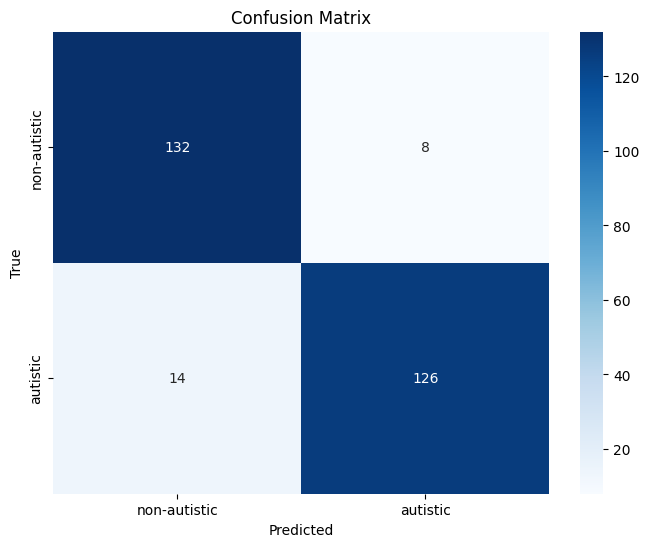

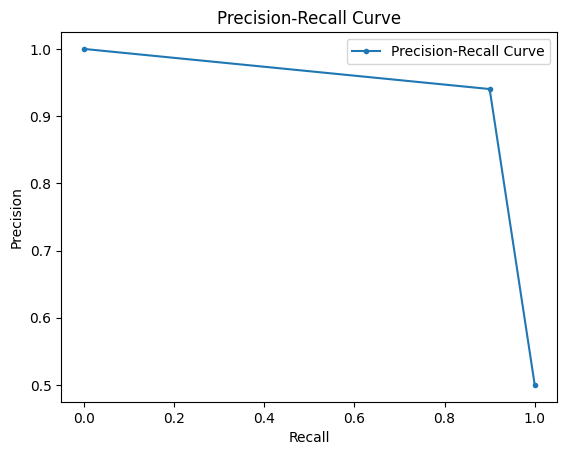

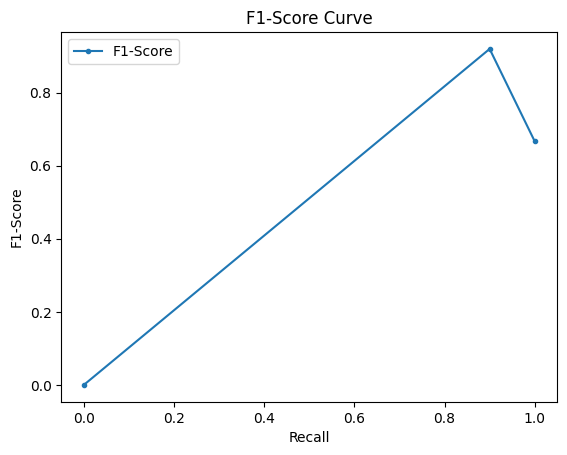

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time


start_time = time.time()
class TimeLimitCallback(Callback):
    def __init__(self, max_duration=3600):
        super(TimeLimitCallback, self).__init__()
        self.max_duration = max_duration
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if time.time() - self.start_time > self.max_duration:
            print("Stopping training as the time limit has been reached.")
            self.model.stop_training = True

train_dir = '/content/drive/MyDrive/ITH_dataset/train'
valid_dir = '/content/drive/MyDrive/ITH_dataset/valid'
test_dir = '/content/drive/MyDrive/ITH_dataset/test'

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-30]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
time_limit = TimeLimitCallback(max_duration=3600)

step1_end = time.time()

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[early_stopping, time_limit, reduce_lr]
)

model.save('asd_mobilenet.h5')

step2_end = time.time()

test_loss, test_accuracy, test_auc = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.2f}, AUC: {test_auc:.2f}")
step3_end = time.time()

predictions = (model.predict(test_generator) > 0.5).astype("int32")
true_labels = test_generator.classes

report = classification_report(true_labels, predictions, target_names=['non-autistic', 'autistic'])
print(report)

conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['non-autistic', 'autistic'],
            yticklabels=['non-autistic', 'autistic'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("cm_mobilenet.png")
print("Confusion matrix saved as 'cm_mobilenet.png'.")

precision, recall, _ = precision_recall_curve(true_labels, predictions)
f1_scores = 2 * (precision * recall) / (precision + recall)

plt.figure()
plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig("prc_mobilenet.png")
print("Precision-recall curve saved as 'prc_mobilenet.png'.")

plt.figure()
plt.plot(recall, f1_scores, marker='.', label="F1-Score")
plt.xlabel('Recall')
plt.ylabel('F1-Score')
plt.title('F1-Score Curve')
plt.legend()
plt.savefig("f1_mobilenet.png")
print("F1-score curve saved as 'f1_mobilenet.png'.")

with open("report_mobilenet.txt", "w") as f:
    f.write(report)
print("Classification report saved as 'report_mobilenet.txt'.")

print(f"Data preparation time: {step1_end - start_time:.2f} seconds.")
print(f"Model training time: {step2_end - step1_end:.2f} seconds.")
print(f"Evaluation time: {step3_end - step2_end:.2f} seconds.")
print(f"Total computational time: {step3_end - start_time:.2f} seconds.")